In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation,AlphaDropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,SeparableConv2D,GlobalAveragePooling2D
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

from google.colab import drive
drive.mount('/content/gdrive/')
#!ls gdrive/My\ Drive
from keras.models import load_model
from pathlib import Path
filePath = Path("/content/gdrive/My Drive")


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
num_classes = 10
dropout_rate = 0.2
weight_decay=1e-6

In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 42s 0us/step


In [0]:
def visualizeAugmentation(visualize=False , data=x_train):
  datagen = ImageDataGenerator(rotation_range=15,
                               zoom_range=0.3,
                                 horizontal_flip=True)
  datagen.fit(data)
  if visualize:
    no_of_images=len(data)
    fig = plt.figure(figsize=(10,10))
    for x_batch  in datagen.flow(data,batch_size=no_of_images):
      for i in range(no_of_images):
        ax=fig.add_subplot(7,8,i+1)
        ax2 = fig.add_subplot(7,8,i+1+no_of_images)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.grid(False)
        ax2.imshow(data[i])
        ax2.set_xlabel(f"original {i+1}")
        ax.imshow(x_batch[i].astype(np.uint8))
        ax.set_xlabel(f"Aug {i+1}")
      plt.show()
      break
  else:
    return datagen
#visualizeAugmentation(visualize=True , data=x_train[0:27])

In [0]:
#DenseNet-BC 121
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2,dense_block_number=1 , l=12):
    temp = input
    for i in range(l):
        # 1x1 Convolution (Bottleneck layer)  
        bn_batch  = BatchNormalization(beta_regularizer=l2(weight_decay),gamma_regularizer=l2(weight_decay))(temp)
        bn_relu = Activation("relu")(bn_batch)
        bn_layer = Conv2D(4*num_filter, 
                            (1,1),
                            use_bias=False,
                            name=f"bottleneckconv2d_{i}_layer_Dense_{dense_block_number}",
                            kernel_initializer="he_uniform",
                            padding="same",
                            kernel_regularizer=l2(weight_decay))(bn_relu)

        if dropout_rate >0 :
          bn_layer = Dropout(dropout_rate)(bn_layer)
        
        #3x3 convolution (Normal Layer)
        BatchNorm = BatchNormalization(beta_regularizer=l2(weight_decay),gamma_regularizer=l2(weight_decay))(bn_layer)
        
        relu = Activation("relu")(BatchNorm)
        Conv2D_3_3 = Conv2D(num_filter, 
                            (3,3),
                            use_bias=False,
                            name=f"conv2d_{i}_layer_Dense_{dense_block_number}",
                            kernel_initializer="he_uniform",
                            padding="same",
                            kernel_regularizer=l2(weight_decay))(relu)
        
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    BatchNorm = BatchNormalization(beta_regularizer=l2(weight_decay),gamma_regularizer=l2(weight_decay))(input)
        
    relu = Activation("relu")(BatchNorm)
        
    Conv2D_BottleNeck = Conv2D(num_filter, 
                            (1,1),
                            use_bias=False,
                            kernel_initializer="he_uniform",
                            padding="same",
                            kernel_regularizer=l2(weight_decay))(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    BatchNorm = BatchNormalization(gamma_regularizer=l2(weight_decay),
                                       beta_regularizer=l2(weight_decay))(input)
    relu = Activation("relu")(BatchNorm)
    globalPool = GlobalAveragePooling2D(data_format=k.image_data_format())(relu)
    output = Dense(num_classes, activation='softmax',kernel_regularizer=l2(weight_decay))(globalPool)
    return output

In [0]:
import math
growth_rate=12
num_filter = 5*growth_rate
depth=100
reduction=0.6
no_layer_per_block = (depth-4)//6

input = Input(shape=(img_height, img_width, channel))
First_Conv2D = Conv2D(num_filter, 
                            (3,3),
                            use_bias=False,
                            kernel_initializer="he_uniform",
                            padding="same",
                            name="Intial_Conv2d",
                            kernel_regularizer=l2(weight_decay))(input)

First_Block = add_denseblock(First_Conv2D, growth_rate, dropout_rate=0.0,dense_block_number=1,l=no_layer_per_block)
num_filter = math.floor((num_filter+(no_layer_per_block*growth_rate))*reduction)
First_Transition = add_transition(First_Block,num_filter , dropout_rate=0.0 )

Second_Block = add_denseblock(First_Transition, growth_rate, dropout_rate=0.1,dense_block_number=2 ,l=no_layer_per_block)
num_filter = math.floor((num_filter+(no_layer_per_block*growth_rate))*reduction)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate=0.0)

Third_Block = add_denseblock(Second_Transition, growth_rate, dropout_rate=0.15,dense_block_number=3,l=no_layer_per_block)

output = output_layer(Third_Block)
model = Model(inputs=input, outputs=output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Intial_Conv2d (Conv2D)          (None, 32, 32, 60)   1620        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 32, 32, 60)   240         Intial_Conv2d[0][0]              
__________________________________________________________________________________________________
activation_100 (Activation)     (None, 32, 32, 60)   0           batch_normalization_100[0][0]    
__________________________________________________________________________________________________
bottleneck

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1,decay=1e-6,nesterov=True,momentum=0.9),
              metrics=['accuracy'])

In [0]:
filepath = "Saved_model.hdf5"
def schedule(epoch):
  if 0 <= epoch <=5:
    lr = 0.1
    print (lr,epoch)
    return lr
  elif 5<= epoch <=15:
    lr = 0.01
    print (lr,epoch)
    return lr
  elif 15<= epoch <=50:
    lr = 0.001
    print (lr,epoch)
    return lr
  elif 51<= epoch <=65:
    lr = 0.0005
    print (lr,epoch)
    return lr 
  elif 66<= epoch <=80:
    lr = 0.0003
    print (lr,epoch)
    return lr
  elif 81<= epoch <=95:
    lr = 0.0001
    print (lr,epoch)
    return lr
  else:
    lr = 0.00001
    print (lr,epoch)
    return lr

def callbacks(patience=3, scheduler=True):
# callback for learning rate reduction
  if scheduler:
    learning_rate_reduction = LearningRateScheduler(schedule)
  else:  
    learning_rate_reduction = ReduceLROnPlateau(monitor = "val_acc",
                                           patience=patience,
                                           verbose=1,
                                           factor=np.sqrt(0.1),
                                           min_lr=1e-7)
  
#callback to save the model as an checkpoint
  checkpoint = ModelCheckpoint(filepath , 
                             monitor="val_acc" ,
                             verbose=1 ,
                             mode="max",
                             save_best_only=True)                             
  return [learning_rate_reduction,checkpoint]

In [0]:

#first 50 Epoch 
batch_size = 64
epochs = 50
def dataAugmentation(dataAug=False,model=model,callbacks=callbacks(scheduler=False)):
  if dataAug:
    #print("using real time dataAug")
    datagen = visualizeAugmentation(visualize=False)
    return model.fit_generator(datagen.flow(x_train,y_train,
                                     batch_size=batch_size,
                                     shuffle=True),
                          steps_per_epoch = x_train.shape[0]//batch_size,
                          epochs=epochs,
                          validation_data=(x_test,y_test),
                          callbacks=callbacks)
  else:
    #print("Not using DataAug")
    return model.fit(x_train,y_train,
             batch_size=batch_size,
             epochs=epochs,
             validation_data=(x_test , y_test),
             shuffle=True,
             callbacks=callbacks)
history = dataAugmentation(True)

Epoch 1/50
781/781 [==============================] - 480s 615ms/step - loss: 1.4724 - acc: 0.4725 - val_loss: 2.5615 - val_acc: 0.3807

Epoch 00001: val_acc improved from -inf to 0.38070, saving model to Saved_model.hdf5
Epoch 2/50
781/781 [==============================] - 447s 572ms/step - loss: 1.0370 - acc: 0.6391 - val_loss: 1.5172 - val_acc: 0.5414

Epoch 00002: val_acc improved from 0.38070 to 0.54140, saving model to Saved_model.hdf5
Epoch 3/50
781/781 [==============================] - 447s 572ms/step - loss: 0.8624 - acc: 0.7057 - val_loss: 1.7615 - val_acc: 0.5610

Epoch 00003: val_acc improved from 0.54140 to 0.56100, saving model to Saved_model.hdf5
Epoch 4/50
781/781 [==============================] - 446s 571ms/step - loss: 0.7398 - acc: 0.7503 - val_loss: 1.0936 - val_acc: 0.6632

Epoch 00004: val_acc improved from 0.56100 to 0.66320, saving model to Saved_model.hdf5
Epoch 5/50
781/781 [==============================] - 446s 571ms/step - loss: 0.6750 - acc: 0.7730 - va

In [0]:
#model=load_model(filepath)
#model.save(filePath / str(filepath+"93"))
#!mv Saved_model.hdf5 Saved_model_93_01.hdf5
#!ls
#filepath
#!mv Saved_model_93_01.hdf5 gdrive/My\ Drive


In [0]:
li= {0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [0]:
from tqdm import tqdm
train_array = []
a = tqdm(zip(x_train , y_train))
i=0
for img , label in a:
  img_ex = np.expand_dims(img,axis=0)
  if np.argmax(model.predict(img_ex)) != np.argmax(label):
    train_array.append((img,label))
  
len(train_array)

50000it [24:22, 34.81it/s]


1735

In [0]:
from tqdm import tqdm
test_array = []
a = tqdm(zip(x_test , y_test))
for img , label in a:
  img_ex = np.expand_dims(img,axis=0)
  p= np.argmax(model.predict(img_ex))
  if p != np.argmax(label):
    test_array.append((img,label ,p ))
len(test_array)

10000it [04:54, 34.03it/s]


0

In [0]:
s = [(x,li[np.argmax(y)] , li[z])for x , y ,z in test_array]

937

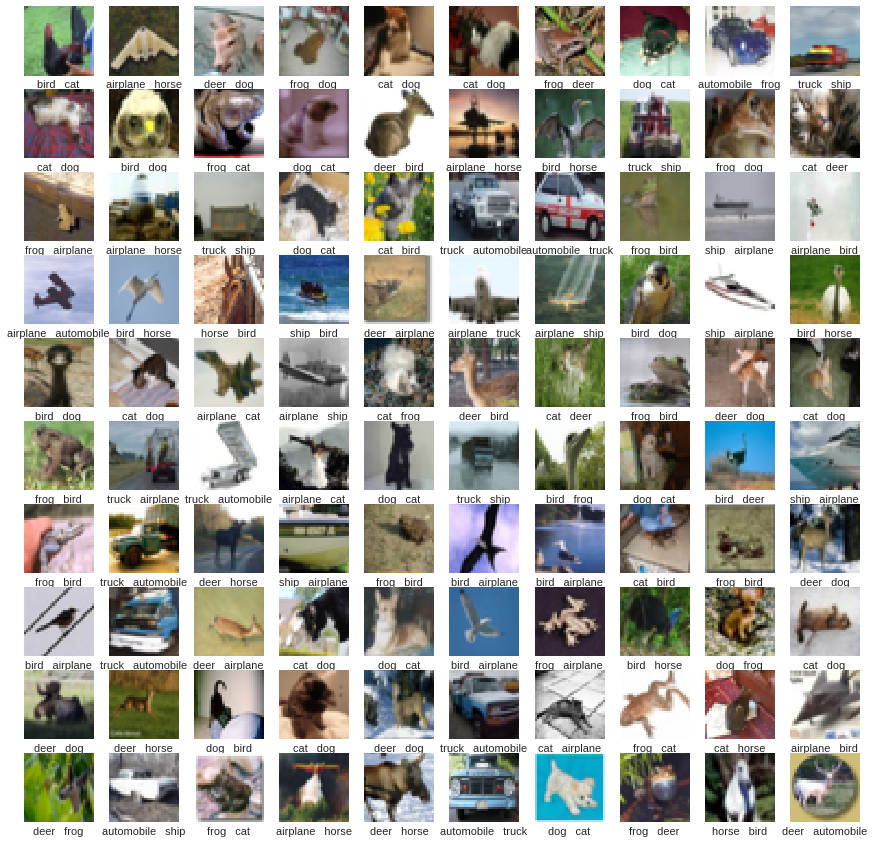

In [0]:
#visualize all the wrong predictions
def visualize( data):
    no_of_images=len(data)
    fig = plt.figure(figsize=(15,15))
    for i in range(no_of_images):
        ax=fig.add_subplot(10,10,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.imshow(data[i][0].astype(np.uint8))
        ax.set_xlabel(f"{data[i][1]}   {data[i][2]}")
    plt.show()
visualize( data=s[0:100])

In [0]:

s_d = [(y,z) for x ,y,z in s]
df = pd.DataFrame(s_d)

In [0]:
gr = df.groupby([0,1])

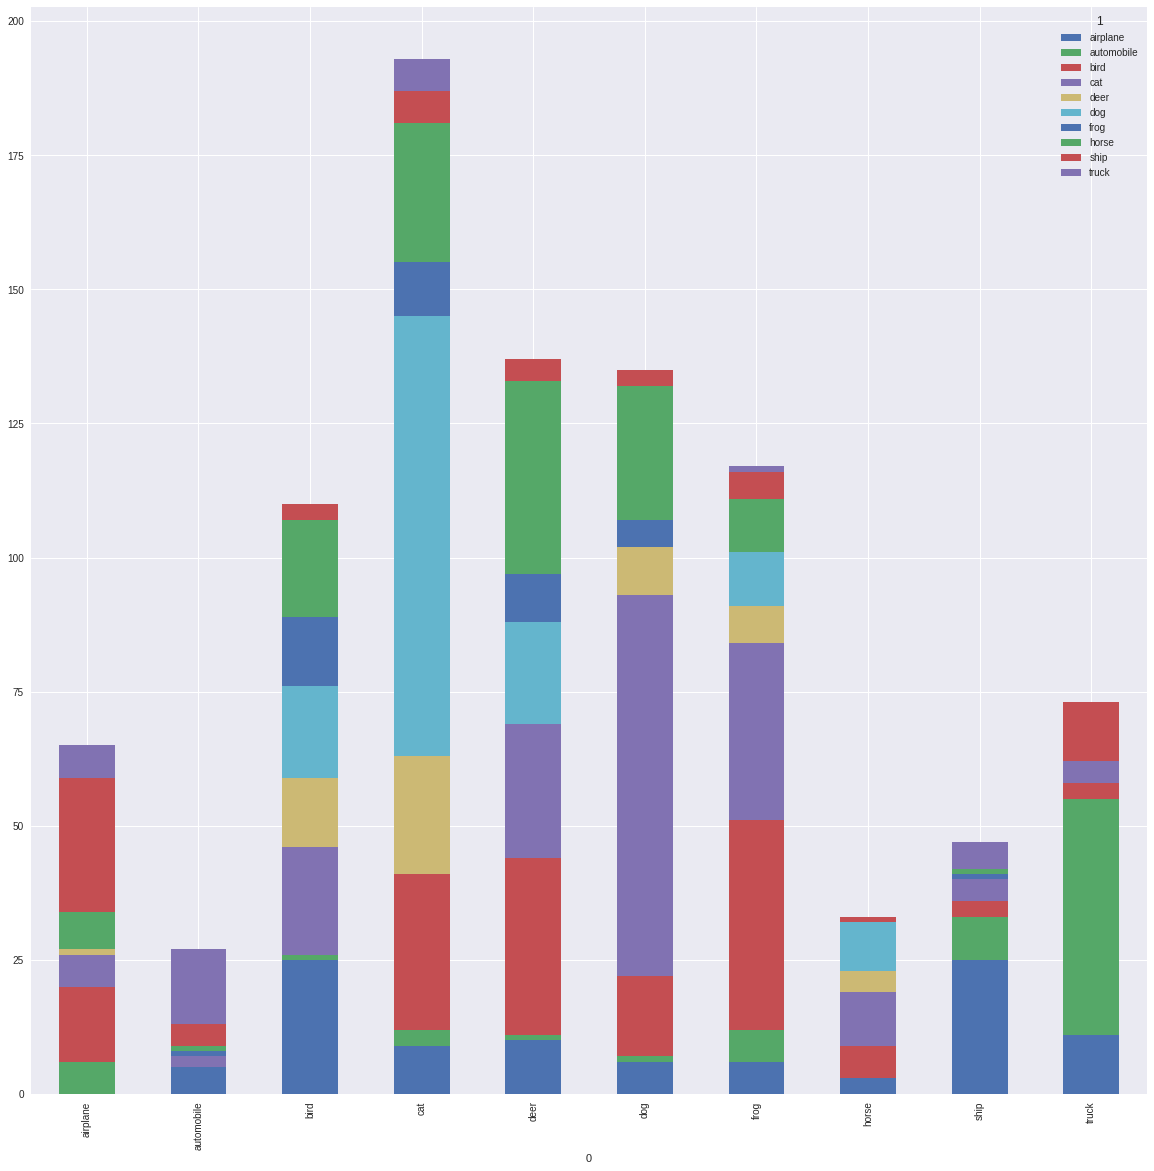

In [0]:
#checking what and all wrong predictions model is making so by visualizing this graph we can see model is confused between dogs and cats
#also it is confused among Aeroplane ,ship and bird, I think becuase blue background so zoom augmentation will improve the model
gr.apply(len).unstack().plot(kind='bar', stacked=True, figsize=(20,20)).get_figure().savefig(str(filePath)+"/fds.png",dpi ='figure',quality=100)

In [0]:
x_nsuc_train = np.array([x[0]for x in train_array])

In [0]:
y_nsuc_train = np.array([x[1] for x in train_array])

In [0]:
# second 12 epoch
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-3,decay=1e-7,nesterov=True,momentum=0.9),
              metrics=['accuracy'])#second 50 Epoch 
batch_size = 48
epochs = 12
def dataAugmentation(dataAug=False,model=model,callbacks=callbacks(patience=1,scheduler=False)):
  earlystop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)
  callbacks.append(earlystop)
  if dataAug:
    #print("using real time dataAug")
    datagen = visualizeAugmentation(visualize=False)
    return model.fit_generator(datagen.flow(x_train,y_train,
                                     batch_size=batch_size,
                                     shuffle=True),
                          steps_per_epoch = x_train.shape[0]//batch_size,
                          epochs=epochs,
                          validation_data=(x_test,y_test),
                          callbacks=callbacks)
  else:
    #print("Not using DataAug")
    return model.fit(x_train,y_train,
             batch_size=batch_size,
             epochs=epochs,
             validation_data=(x_test , y_test),
             shuffle=True,
             callbacks=callbacks)
history = dataAugmentation(True)

Epoch 1/12
1041/1041 [==============================] - 517s 497ms/step - loss: 0.1918 - acc: 0.9432 - val_loss: 0.3000 - val_acc: 0.9178

Epoch 00001: val_acc improved from -inf to 0.91780, saving model to Saved_model.hdf5
Epoch 2/12
1041/1041 [==============================] - 488s 469ms/step - loss: 0.1959 - acc: 0.9421 - val_loss: 0.3014 - val_acc: 0.9184

Epoch 00002: val_acc improved from 0.91780 to 0.91840, saving model to Saved_model.hdf5
Epoch 3/12
1041/1041 [==============================] - 488s 469ms/step - loss: 0.1963 - acc: 0.9413 - val_loss: 0.3025 - val_acc: 0.9192

Epoch 00003: val_acc improved from 0.91840 to 0.91920, saving model to Saved_model.hdf5
Epoch 4/12
1041/1041 [==============================] - 488s 469ms/step - loss: 0.1937 - acc: 0.9432 - val_loss: 0.3024 - val_acc: 0.9196

Epoch 00004: val_acc improved from 0.91920 to 0.91960, saving model to Saved_model.hdf5
Epoch 5/12
1041/1041 [==============================] - 488s 469ms/step - loss: 0.1923 - acc: 0

In [0]:
# Test the model
# Total Epoch 62  with Augmentation
score = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', score[1])
print('Test loss:', score[0])

10000/10000 [==============================] - 41s 4ms/step
Test accuracy: 0.9208
Test loss: 0.30013608413934706


In [0]:
#third 10 epoch
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-5,decay=1e-6,nesterov=True,momentum=0.9),
              metrics=['accuracy'])#second 50 Epoch 
batch_size = 48
epochs = 10
def dataAugmentation(dataAug=False,model=model,callbacks=callbacks(patience=1,scheduler=False)):
  earlystop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)
  callbacks.append(earlystop)
  if dataAug:
    #print("using real time dataAug")
    datagen = visualizeAugmentation(visualize=False)
    return model.fit_generator(datagen.flow(x_train,y_train,
                                     batch_size=batch_size,
                                     shuffle=True),
                          steps_per_epoch = x_train.shape[0]//batch_size,
                          epochs=epochs,
                          validation_data=(x_test,y_test),
                          callbacks=callbacks)
  else:
    #print("Not using DataAug")
    return model.fit(x_train,y_train,
             batch_size=batch_size,
             epochs=epochs,
             validation_data=(x_test , y_test),
             shuffle=True,
             callbacks=callbacks)
history = dataAugmentation(False)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 517s 10ms/step - loss: 0.1178 - acc: 0.9711 - val_loss: 0.2496 - val_acc: 0.9294

Epoch 00001: val_acc improved from -inf to 0.92940, saving model to Saved_model.hdf5
Epoch 2/10
50000/50000 [==============================] - 479s 10ms/step - loss: 0.1172 - acc: 0.9703 - val_loss: 0.2498 - val_acc: 0.9295

Epoch 00002: val_acc improved from 0.92940 to 0.92950, saving model to Saved_model.hdf5
Epoch 3/10
50000/50000 [==============================] - 479s 10ms/step - loss: 0.1165 - acc: 0.9713 - val_loss: 0.2504 - val_acc: 0.9301

Epoch 00003: val_acc improved from 0.92950 to 0.93010, saving model to Saved_model.hdf5
Epoch 4/10
50000/50000 [==============================] - 479s 10ms/step - loss: 0.1183 - acc: 0.9705 - val_loss: 0.2497 - val_acc: 0.9296

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.

Epoch 00004: val_acc did not improve from 0.930

In [0]:
# Test the model
# Total Epoch 62  with Augmentation and 3 more without augmentation = 65 epochs
# accuracy gain of 1 %
score = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', score[1])
print('Test loss:', score[0])

10000/10000 [==============================] - 59s 6ms/step
Test accuracy: 0.9301
Test loss: 0.25037472605705263
